In [18]:
import pandas as pd
import numpy as np

**we can take data from direct website also just use pandas_reader library**

In [6]:
#import pandas_datareader as pdr
#key=""
#df = pdr.get_data_tiingo('AAPL', api_key=key)
#df.to_csv('AAPL.csv')

we are taking data using github raw data url.

In [7]:
url = 'https://raw.githubusercontent.com/krishnaik06/Stock-MArket-Forecasting/master/AAPL.csv'
data =pd.read_csv(url)

In [9]:
data.head(2)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.26,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.95,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0


In [5]:
data.shape

(1258, 15)

In [8]:
data.tail(2)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.87,318.66,25672211,316.85,320.89,315.87,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.35,315.77,20450754,318.89,319.23,315.35,315.77,20450754,0.0,1.0


In [10]:
df1=data.reset_index()['close']
# reset_index() is used to reset index mostly used with groupby()

In [11]:
df1.head(2)

0    132.045
1    131.780
Name: close, dtype: float64

In [19]:
type(df1)

pandas.core.series.Series

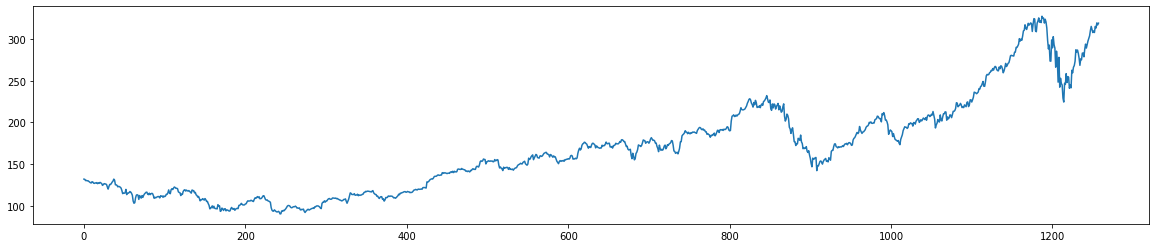

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))           
plt.plot(df1)
#https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.plot.html

**LSTM are sensitive to the scale of the data. so we apply MinMax scaler**

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
type(df1)

numpy.ndarray

In [22]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [23]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [24]:
training_size,test_size

(817, 441)

**most imp concept while preperating data to feed LSTM**

In [25]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1): # we have to exclude last 99 data***
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99--->X   100---->Y 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])###??????????
	return numpy.array(dataX), numpy.array(dataY)

In [26]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [29]:
# reshape input to be [samples, time steps, features] which is required for LSTM ?????????????????
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [30]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 3s 270ms/step - loss: 0.0142 - val_loss: 0.0603
Epoch 2/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/100
12/12 [==============================] - 2s 188ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 4/100
12/12 [==============================] - 2s 188ms/step - loss: 7.3748e-04 - val_loss: 0.0057
Epoch 5/100
12/12 [==============================] - 2s 188ms/step - loss: 6.4102e-04 - val_loss: 0.0051
Epoch 6/100
12/12 [==============================] - 2s 191ms/step - loss: 6.2328e-04 - val_loss: 0.0045
Epoch 7/100
12/12 [==============================] - 2s 190ms/step - loss: 6.4318e-04 - val_loss: 0.0048
Epoch 8/100
12/12 [==============================] - 2s 188ms/step - loss: 6.0037e-04 - val_loss: 0.0049
Epoch 9/100
12/12 [==============================] - 2s 189ms/step - loss: 6.0679e-04 - val_loss: 0.0042
Epoch 10/100
12/12 [==============================] - 2s 189ms/step

In [32]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [33]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [34]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

144.6983334575643

In [35]:
math.sqrt(mean_squared_error(ytest,test_predict))

252.1922249538394

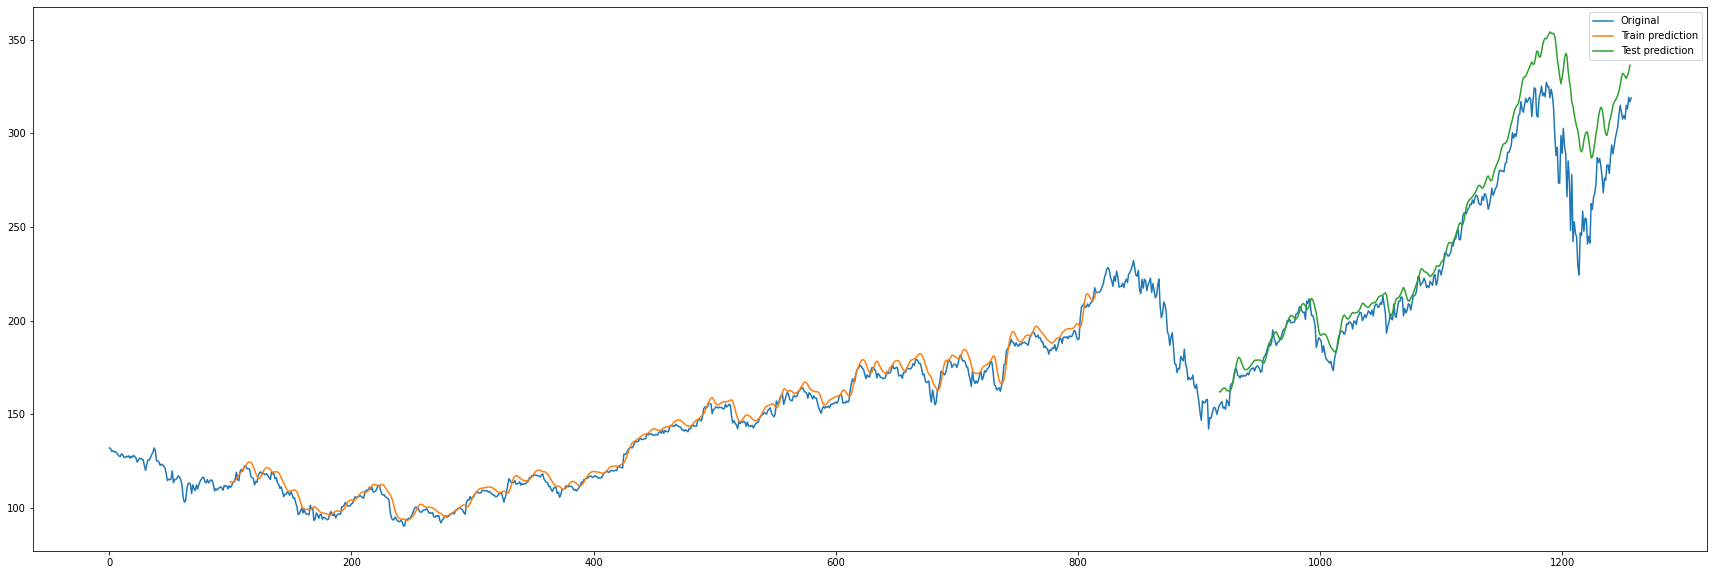

In [44]:
# shift train predictions for plotting
look_back=100

# reshape the figure
plt.figure(figsize=(30,10))

#first make empty numpy array of same size of df1
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# For plotting purpose we use following
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1),label='Original')
plt.plot(trainPredictPlot,label='Train prediction')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()